<!--<div align="center">Семинар № 2-->

<div align="center"><font color=#4682B4 size=4 face=
                          "arial black"><em><strong>Семинар № 8</strong></em></font></div>

<div class="alert alert-block alert-info"><em>
<b>Задача.</b><br>
На сайте запущен А/В тест с целью увеличить доход.<br>
В приложенном excel файле вы найдете сырые данные по результатам эксперимента – <b>user_id</b>,<br>
тип выборки <b>variant_name</b> и доход принесенный пользователем <b>revenue</b>.<br>
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
</em></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
df_00 = pd.read_excel('AB_Test_Results.xlsx')
df_00.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [3]:
df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 195.4+ KB


In [4]:
df_00.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


 <font color='LimeGreen' size=3 >
 1. 10 000 строк;<br>
 2. пропущенных значений нет; <br>
 3. почти все данные в 1 квартиле;</font>

In [5]:
df_cou = df_00.groupby(['VARIANT_NAME']).agg({'USER_ID':['count']})
df_cou.columns = ['users_all']
df_cou

,users_all
VARIANT_NAME,
control,4984
variant,5016


In [6]:
df_11 = df_00[df_00.REVENUE != 0]
df_buy = df_11.groupby(['VARIANT_NAME']).agg({'USER_ID':['count']})
df_buy.columns = ['users_buy']
df_buy

,users_buy
VARIANT_NAME,
control,80
variant,72


In [7]:
print(f'конверсия в доход:\n  control  {80/4984*100:.3f} %\n  variant  {72/5016*100:.3f} %')

конверсия в доход:
  control  1.605 %
  variant  1.435 %


<font color='LimeGreen' size=3 >5. Тестовая конверсия меньше контрольной.<br>
 Странно... А общий доход по группам?</font>

In [8]:
df_11.groupby(['VARIANT_NAME']).agg({'REVENUE':['sum']})

,REVENUE
,sum
VARIANT_NAME,
control,643.00
variant,351.47


<font color='LimeGreen' size=3 > 6. Суммарный доход в тестовой группе меньше почти в два раза.<br>
Посмотрим на выбросы.</font>

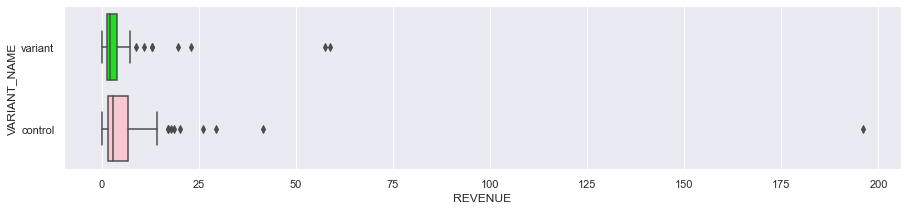

In [9]:
sbn.set(rc = {'figure.figsize':(15, 3)})
sbn.boxplot(data=df_11, x='REVENUE', y='VARIANT_NAME', palette=["lime", "pink"]);

<font color='LimeGreen' size=3 >Из условия задачи неясно, что есть выбросы. Удалим примерно 5 % всех покупок.</font>

In [10]:
df_11[df_11.REVENUE >= 20].count()

USER_ID         8
VARIANT_NAME    8
REVENUE         8
dtype: int64

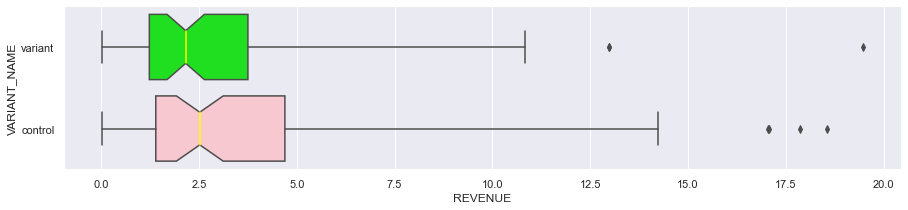

In [11]:
df_cl_20 = df_11[df_11.REVENUE < 20]
sbn.boxplot(data=df_cl_20, x='REVENUE', y='VARIANT_NAME', palette=["lime", "pink"], whis=3, 
        notch=True, medianprops={"color": "yellow"});

In [12]:
df_cl_20[df_cl_20.VARIANT_NAME == 'control'].describe()

,USER_ID,REVENUE
count,75.000000,75.000000
mean,4570.293333,4.401200
std,2831.884960,4.679331
min,124.000000,0.020000
25%,2098.500000,1.395000
50%,4724.000000,2.520000
75%,6650.500000,4.695000
max,9766.000000,18.560000


In [13]:
df_cl_20[df_cl_20.VARIANT_NAME == 'variant'].describe()

,USER_ID,REVENUE
count,69.000000,69.000000
mean,5284.898551,3.077391
std,3152.702931,3.366475
min,56.000000,0.020000
25%,2529.000000,1.230000
50%,5597.000000,2.160000
75%,8110.000000,3.750000
max,9996.000000,19.470000


In [14]:
df_cl_20.groupby(['VARIANT_NAME']).agg({'REVENUE':['sum']})

,REVENUE
,sum
VARIANT_NAME,
control,330.09
variant,212.34


<font color='LimeGreen' size=3 >
7. Среднее значение контрольной группы больше среднего тестовой более 40 %.<br>    
    После удаления выбросов лучше не стало:<br>
    контрольная группа выглядит существенно лучше тестовой.
    
***
    
 Проверим на нормальность.</font>   

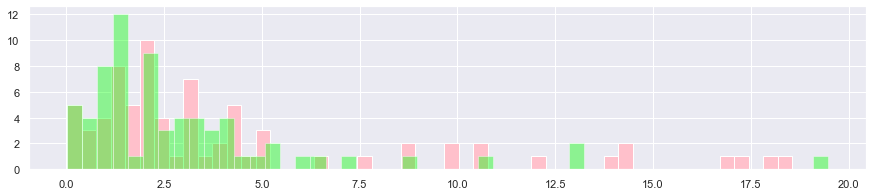

In [15]:
cont_rev = df_cl_20[df_cl_20.VARIANT_NAME == 'control'].REVENUE
var_rev = df_cl_20[df_cl_20.VARIANT_NAME == 'variant'].REVENUE
plt.hist(cont_rev, color='pink', alpha=1, bins=50)
plt.hist(var_rev, color='lime', alpha=0.4, bins=50)
plt.show()

<font color='LimeGreen' size=3> Видим длиный правый хвост: проверим
    на логнормальное распределение.</font>

In [16]:
import numpy as np
import scipy.stats as st
cont_rev_log = cont_rev.apply(np.log)
var_rev_log = var_rev.apply(np.log)

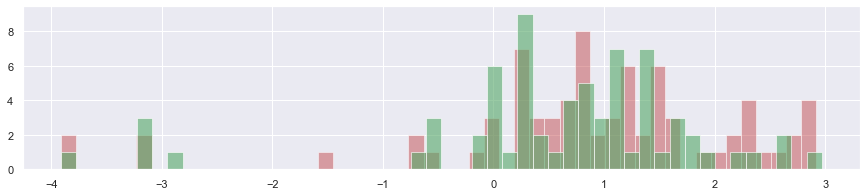

In [17]:
plt.hist(cont_rev_log, color='r', alpha=.5, bins=50)
plt.hist(var_rev_log, color='g', alpha=.6, bins=50)
plt.show()

In [18]:
st.shapiro(cont_rev_log), st.shapiro(var_rev_log)

(ShapiroResult(statistic=0.864271342754364, pvalue=9.826070481722127e-07),
 ShapiroResult(statistic=0.8569685816764832, pvalue=1.2945885146109504e-06))

<font color='LimeGreen' size=3> Выборки имеют ненормальное распределение.<br>
Применим непараметрический **тест Манна-Уитни** для двух выборок.</font>

In [19]:
s, pv_20 = st.mannwhitneyu(cont_rev, var_rev)
f'pvalue (< 20) = {pv_20 * 100:.1f} %'

'pvalue (< 20) = 4.8 %'

<font color='LimeGreen' size=3> **pvalue = 4,8 % меньше $\alpha$ = 5 %** :<br>
    различия в выборках статистически значимы.
    
***
Посмотрим, есть ли пересечения в группах.
</font>

In [20]:
con_id_00 = list(df_00[df_00.VARIANT_NAME == 'control'].USER_ID)
var_id_00 = list(df_00[df_00.VARIANT_NAME == 'variant'].USER_ID)
gen_id_00 = [_ for _ in var_id_00 if _ in con_id_00] # Список общих ID в двух группах 
print(f'{len(gen_id_00)} общих ID в двух группах.')                  

1972 общих ID в двух группах.


In [21]:
con_id_11 = list(df_11[df_11.VARIANT_NAME == 'control'].USER_ID)
var_id_11 = list(df_11[df_11.VARIANT_NAME == 'variant'].USER_ID)
gen_id_11 = [_ for _ in var_id_11 if _ in con_id_11] # Список общих ID в двух группах с доходом
print(f'{len(gen_id_11)} общих ID в двух группах с доходом.\n\nНайдём их:') 

1 общих ID в двух группах с доходом.

Найдём их:


In [22]:
df_11[df_11.USER_ID == gen_id_11[0]]

,USER_ID,VARIANT_NAME,REVENUE
4123,1252,variant,1.25
8108,1252,control,1.26


<div class="alert alert-block alert-success"><em>
<b>Рекомендации менеджеру :</b><br>В результате анализа было выявлено статистически значимое <b>существенное ухудшение</b><br>
 ряда метрик в сравнении с контрольной группой.<br>
 Присутствует почти 40 % одних и тех же пользователей в обеих группах.<br> 
1. Проведённый тест достоверно можно считать <b>ухудшающим</b>.<br>
2. Проанализировать выборки групп перед проведением эксперимента.
</em></div>

***